<img src="https://github.com/nicholasmetherall/digital-earth-pacific-macblue-activities/blob/main/attachments/images/DE_Pacific_banner.JPG?raw=true" width="900"/>
Figure 1.1.a. Jupyter environment + Python notebooks

### Digital Earth Pacific Notebook 1 prepare postcard and load data to csv

<font color='green'>The objective of this notebook is to prepare a geomad postcard for your AOI (masking, scaling and loading additional band ratios and spectral indices) and sampling all the datasets into a csv based on your training data geodataframe. </font>

<font color='blue'>Step 1.1</font>

In [2]:
from pystac_client import Client
from dask.distributed import Client as DaskClient
from odc.stac import load, configure_s3_access
import rasterio as rio
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import folium
import utils
from utils import load_data
from utils import mask_and_scale
from sklearn.ensemble import RandomForestClassifier
import odc.geo.xr
import rioxarray
import matplotlib.pyplot as plt
import joblib
from shapely.geometry import box

<font color='blue'>Define catalogue</font>

In [3]:
catalog = "https://stac.digitalearthpacific.org"
client = Client.open(catalog)

In [4]:
# ba_gdf = gpd.read_file("training_data/bootless_bay_bounds.geojson")
# ba_gdf = ba_gdf.to_crs("EPSG:4326")
# min_lon, min_lat, max_lon, max_lat = ba_gdf.total_bounds
# bbox = [min_lon, min_lat, max_lon, max_lat]

In [5]:
bbox = gpd.read_file("training_data/bootless_bay.geojson")
# ba_gdf = ba_gdf.to_crs("EPSG:4326")
min_lon, min_lat, max_lon, max_lat = bbox.total_bounds
bbox = [min_lon, min_lat, max_lon, max_lat]

In [6]:
datetime="2024"
items = list(client.search(collections=["dep_s2_geomad"], datetime=datetime, bbox=bbox).items())

In [7]:
from pystac import Collection

In [8]:
collection = Collection.from_file("https://stac.digitalearthpacific.org/collections/dep_s2_geomad")

In [9]:
data = load(
        items,
        measurements=[
            "nir", "red", "blue", "green", "emad", "smad", 
            "bcmad", "count", "green", "nir08", 
            "nir09", "swir16", "swir22", "coastal",
            "rededge1", "rededge2", "rededge3", 
        ],
        bbox=bbox,
        chunks={"x": 2048, "y": 2048},
        groupby="solar_day",
    )

In [10]:
# dask_client = DaskClient(n_workers=1, threads_per_worker=16, memory_limit='16GB')
# configure_s3_access(cloud_defaults=True, requester_pays=True)

In [56]:
scaled = (data.where(data != 0) * 0.0001).clip(0, 1)

In [57]:
mndwi = (scaled["green"]-scaled["swir16"])/(scaled["green"]+scaled["swir16"])
mndwi_land_mask = mndwi > 0
clipped_ds = scaled.where(mndwi_land_mask)

In [58]:
ndti = (clipped_ds["red"]-clipped_ds["green"])/(clipped_ds["red"]+clipped_ds["green"])
ndti_mask = ndti < 0.2
clipped_ds = clipped_ds.where(ndti_mask)

In [59]:
nir = clipped_ds['nir']
nir_mask = nir < 0.085
clipped_ds = clipped_ds.where(nir_mask)

In [60]:
all_masks = (mndwi_land_mask+ndti_mask+nir_mask)

In [61]:
# Incorporate other band ratios and indices
cai = (clipped_ds["coastal"]-clipped_ds["blue"])/( clipped_ds["coastal"]+ clipped_ds["blue"]) #coastal aerosol index
ndvi = (clipped_ds["nir"]-clipped_ds["red"])/( clipped_ds["nir"]+ clipped_ds["red"]) #vegetation index (NDVI)
ndwi = (clipped_ds["green"]-clipped_ds["nir"])/(clipped_ds["green"]+clipped_ds["nir"]) #water index (NDWI)
b_g = (clipped_ds["blue"])/(clipped_ds["green"]) #blue to green ratio
b_r = (clipped_ds["blue"])/(clipped_ds["red"]) #blue to red ratio
mci = (clipped_ds["nir"])/(clipped_ds["rededge1"]) # max chlorophlyll index (MCI)
ndci = (clipped_ds["rededge1"]-clipped_ds["red"])/(clipped_ds["rededge1"]+clipped_ds["red"]) # normalised difference chlorophyll index (NDCI)


In [62]:
clipped_ds['cai'] = cai
clipped_ds['ndvi'] = ndvi
clipped_ds['ndwi'] = ndwi
clipped_ds['mndwi'] = mndwi
clipped_ds['ndti'] = ndti
clipped_ds['b_g'] = b_g
clipped_ds['b_r'] = b_r
clipped_ds['mci'] = mci
clipped_ds['ndci'] = ndci
# clipped_ds

In [63]:
# clipped_da = clipped_ds.squeeze().to_array(dim="band")
# clipped_da = clipped_da.astype('float32')
# clipped_da.odc.write_cog("clipped_ds_masked.tiff")

### Postcard csv

<font color='green'>The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data. </font>

<font color='blue'>Step 1.2. Input the training data to sample geomad data from the postcard</font>

In [64]:
# Define training data
ba_gdf = gpd.read_file("training_data/ba_data_14032025.geojson")
ba_gdf = ba_gdf.to_crs("EPSG:4326")
# ba_gdf.explore(column="cc_id", legend=True)

In [65]:
ba_postcard = clipped_ds#.where(all_masks)
# ba_postcard =clipped_ds.to_array(dim="band")
# First transform the training points to the same CRS as the data
ba_training = ba_gdf.to_crs(ba_postcard.odc.geobox.crs)

In [66]:
print(ba_training.columns)
ba_training=ba_training.drop(columns=['fid', 'date', 'uuid'])

Index(['fid', 'observed', 'cc_id', 'date', 'uuid', 'geometry'], dtype='object')


In [67]:
ba_training

,observed,cc_id,geometry
0,None,4,POINT (3071647.205 -1955554.241)
1,None,4,POINT (3071739.056 -1955554.241)
2,None,4,POINT (3071691.176 -1955512.481)
3,None,4,POINT (3071691.176 -1955600.858)
4,None,4,POINT (3071691.176 -1955558.126)
...,...,...,...
9730,None,2,POINT (3127375.712 -1943349.709)
9731,None,2,POINT (3127200.055 -1943418.068)
9732,None,2,POINT (3127186.764 -1943427.755)
9733,None,2,POINT (3127198.726 -1943435.68)


In [68]:
ba_training_da = ba_training.assign(x=ba_training.geometry.x, y=ba_training.geometry.y).to_xarray()

In [69]:
ba_training_values = (
    ba_postcard.sel(ba_training_da[["x", "y"]], method="nearest").squeeze().compute().to_pandas()
)
ba_training_values

,nir,red,blue,green,emad,smad,bcmad,count,nir08,nir09,...,time,cai,ndvi,ndwi,mndwi,ndti,b_g,b_r,mci,ndci
index,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-01-01,NaN,NaN,NaN,-0.301604,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-01-01,NaN,NaN,NaN,-0.301604,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-01-01,NaN,NaN,NaN,-0.301604,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-01-01,NaN,NaN,NaN,-0.301604,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-01-01,NaN,NaN,NaN,-0.301604,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-01-01,NaN,NaN,NaN,-0.301604,NaN,NaN,NaN,NaN,NaN
9731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-01-01,NaN,NaN,NaN,-0.301604,NaN,NaN,NaN,NaN,NaN
9732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-01-01,NaN,NaN,NaN,-0.301604,NaN,NaN,NaN,NaN,NaN


In [70]:
# Join the training data with the extracted values and remove unnecessary columns
ba_training_array = pd.concat([ba_training["cc_id"], ba_training_values], axis=1)
# Drop rows where there was no data available
ba_training_array = ba_training_array.dropna()
# Preview our resulting training array
ba_training_array.head()

,cc_id,nir,red,blue,green,emad,smad,bcmad,count,nir08,...,time,cai,ndvi,ndwi,mndwi,ndti,b_g,b_r,mci,ndci


In [71]:
# print(ba_training_array.columns)

In [72]:
# ba_training_array.to_csv("training_data/postcard_ba_dataframe.csv")

### Notebook 2 - Train Random Forest Machine Learning (ML) Model

<font color='green'>Combine the csv geodataframes from notebook 1 into a single csv to train the machine learning model</font>

<font color='blue'>Step 2.1. Concatenating all postcard dataframes</font>

In [73]:
postcard_ba_df = gpd.read_file("training_data/joined_training_data_14032025_test.csv")
postcard_ba_df

,field_1,cc_id,nir,red,blue,green,emad,smad,bcmad,count,...,ndvi,ndwi,mndwi,ndti,b_g,b_r,mci,ndci,y,x
0,0,2,0.0298,0.032899998,0.055999998,0.0436,0.08867363,4.070756e-06,3.3468114e-05,0.0058,...,-0.049441766,0.18801092,0.24039832,-0.13986932,1.2844036,1.7021277,0.884273,0.012012049,-2044675.0,3153725.0
1,1,2,0.0295,0.0326,0.0559,0.043399997,0.08912841,3.7858456e-06,3.3206863e-05,0.0058,...,-0.04991949,0.19067211,0.23646721,-0.14210522,1.2880185,1.714724,0.8727811,0.018072259,-2044665.0,3153725.0
2,2,2,0.0289,0.032199997,0.0552,0.042999998,0.08345044,3.5213677e-06,3.508021e-05,0.0056,...,-0.05400979,0.19610569,0.2463768,-0.14361703,1.283721,1.7142859,0.8626865,0.019786963,-2044635.0,3153725.0
3,3,2,0.03,0.033299997,0.0565,0.0437,0.09336796,3.3604056e-06,3.2506323e-05,0.0058,...,-0.052132674,0.18588874,0.22580643,-0.13506496,1.2929062,1.6966968,0.85470086,0.0263158,-2044655.0,3153725.0
4,4,2,0.0297,0.032199997,0.0563,0.0435,0.08827729,4.1538833e-06,3.362744e-05,0.0058,...,-0.040387686,0.18852457,0.24285713,-0.14927347,1.2942529,1.7484473,0.8839286,0.021276617,-2044695.0,3153725.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15808,15808,2,0.0308,0.037,0.083799995,0.0792,0.09495646,3.7202387e-06,3.477787e-05,0.0036,...,-0.09144544,0.44,0.42446047,-0.36316696,1.0580808,2.2648647,0.82133335,0.0067113736,-1943345.0,3127375.0
15809,15809,2,0.0254,0.098799996,0.14379999,0.1769,0.08679364,2.224499e-06,1.8050527e-05,0.0028,...,-0.5909823,0.74888784,0.7841654,-0.28327894,0.81288856,1.4554656,0.28507295,-0.051623207,-1943415.0,3127205.0
15810,15810,2,0.022499999,0.0896,0.13509999,0.1653,0.07137143,2.0123957e-06,1.4987317e-05,0.0026999998,...,-0.5985727,0.7603834,0.78413385,-0.29697922,0.81730187,1.5078125,0.28662422,-0.066032134,-1943425.0,3127185.0
15811,15811,2,0.0223,0.093899995,0.1432,0.1752,0.06866846,1.9327103e-06,1.5107227e-05,0.0026999998,...,-0.61617905,0.7741772,0.8033969,-0.30211818,0.8173516,1.5250267,0.27063105,-0.06522969,-1943435.0,3127195.0


In [74]:
postcard_ba_df.columns


Index(['field_1', 'cc_id', 'nir', 'red', 'blue', 'green', 'emad', 'smad',
       'bcmad', 'count', 'nir08', 'nir09', 'swir16', 'swir22', 'coastal',
       'rededge1', 'rededge2', 'rededge3', 'cai', 'ndvi', 'ndwi', 'mndwi',
       'ndti', 'b_g', 'b_r', 'mci', 'ndci', 'y', 'x'],
      dtype='object')

In [75]:
# postcard_ba_df.columns
# postcard_ba_df = postcard_ba_df.drop(columns=["spatial_ref", "time", "field_1", "y", "x"])
postcard_ba_df = postcard_ba_df.drop(columns=["field_1"])
postcard_ba_df = postcard_ba_df.drop(columns=["y", "x"])
postcard_ba_df

,cc_id,nir,red,blue,green,emad,smad,bcmad,count,nir08,...,rededge3,cai,ndvi,ndwi,mndwi,ndti,b_g,b_r,mci,ndci
0,2,0.0298,0.032899998,0.055999998,0.0436,0.08867363,4.070756e-06,3.3468114e-05,0.0058,0.0307,...,0.0325,0.058823552,-0.049441766,0.18801092,0.24039832,-0.13986932,1.2844036,1.7021277,0.884273,0.012012049
1,2,0.0295,0.0326,0.0559,0.043399997,0.08912841,3.7858456e-06,3.3206863e-05,0.0058,0.0307,...,0.0326,0.060504165,-0.04991949,0.19067211,0.23646721,-0.14210522,1.2880185,1.714724,0.8727811,0.018072259
2,2,0.0289,0.032199997,0.0552,0.042999998,0.08345044,3.5213677e-06,3.508021e-05,0.0056,0.0295,...,0.0316,0.053984568,-0.05400979,0.19610569,0.2463768,-0.14361703,1.283721,1.7142859,0.8626865,0.019786963
3,2,0.03,0.033299997,0.0565,0.0437,0.09336796,3.3604056e-06,3.2506323e-05,0.0058,0.0316,...,0.0335,0.060681637,-0.052132674,0.18588874,0.22580643,-0.13506496,1.2929062,1.6966968,0.85470086,0.0263158
4,2,0.0297,0.032199997,0.0563,0.0435,0.08827729,4.1538833e-06,3.362744e-05,0.0058,0.03,...,0.031799998,0.056951392,-0.040387686,0.18852457,0.24285713,-0.14927347,1.2942529,1.7484473,0.8839286,0.021276617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15808,2,0.0308,0.037,0.083799995,0.0792,0.09495646,3.7202387e-06,3.477787e-05,0.0036,0.0339,...,0.035,-0.08972689,-0.09144544,0.44,0.42446047,-0.36316696,1.0580808,2.2648647,0.82133335,0.0067113736
15809,2,0.0254,0.098799996,0.14379999,0.1769,0.08679364,2.224499e-06,1.8050527e-05,0.0028,0.0235,...,0.030399999,-0.1811088,-0.5909823,0.74888784,0.7841654,-0.28327894,0.81288856,1.4554656,0.28507295,-0.051623207
15810,2,0.022499999,0.0896,0.13509999,0.1653,0.07137143,2.0123957e-06,1.4987317e-05,0.0026999998,0.0219,...,0.0267,-0.12677228,-0.5985727,0.7603834,0.78413385,-0.29697922,0.81730187,1.5078125,0.28662422,-0.066032134
15811,2,0.0223,0.093899995,0.1432,0.1752,0.06866846,1.9327103e-06,1.5107227e-05,0.0026999998,0.0207,...,0.026099999,-0.1562374,-0.61617905,0.7741772,0.8033969,-0.30211818,0.8173516,1.5250267,0.27063105,-0.06522969


<font color='blue'>Step 2.2. Train the ML model</font>

In [76]:
# The classes are the first column
classes = np.array(postcard_ba_df)[:, 0]

# The observation data is everything after the second column
observations = np.array(postcard_ba_df)[:, 1:]

# Create a model...
classifier = RandomForestClassifier()

# ...and fit it to the data
model = classifier.fit(observations, classes)

In [77]:
# Suppose 'model' is your trained model object
joblib.dump(model, "models/model-geomad-joined-data-ba-rf-14032025.model")


['models/model-geomad-joined-data-ba-rf-14032025.model']

In [78]:
ba_postcard

<xarray.Dataset> Size: 133MB
Dimensions:      (time: 1, y: 1065, x: 1245)
Coordinates:
  * y            (y) float64 9kB -1.052e+06 -1.052e+06 ... -1.063e+06 -1.063e+06
  * x            (x) float64 10kB -3.087e+05 -3.087e+05 ... -2.963e+05
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables: (12/25)
    nir          (time, y, x) float32 5MB dask.array<chunksize=(1, 1065, 1245), meta=np.ndarray>
    red          (time, y, x) float32 5MB dask.array<chunksize=(1, 1065, 1245), meta=np.ndarray>
    blue         (time, y, x) float32 5MB dask.array<chunksize=(1, 1065, 1245), meta=np.ndarray>
    green        (time, y, x) float32 5MB dask.array<chunksize=(1, 1065, 1245), meta=np.ndarray>
    emad         (time, y, x) float32 5MB dask.array<chunksize=(1, 1065, 1245), meta=np.ndarray>
    smad         (time, y, x) float32 5MB dask.array<chunksize=(1, 1065, 1245), meta=np.ndarray>
    ...           ...
    mndwi        (time, y, x) float32 5MB dask.array<chunksize=(1, 1065, 1245), meta=np.ndarray>
    ndti         (time, y, x) float32 5MB dask.array<chunksize=(1, 1065, 1245), meta=np.ndarray>
    b_g          (time, y, x) float32 5MB dask.array<chunksize=(1, 1065, 1245), meta=np.ndarray>
    b_r          (time, y, x) float32 5MB dask.array<chunksize=(1, 1065, 1245), meta=np.ndarray>
    mci          (time, y, x) float32 5MB dask.array<chunksize=(1, 1065, 1245), meta=np.ndarray>
    ndci         (time, y, x) float32 5MB dask.array<chunksize=(1, 1065, 1245), meta=np.ndarray>

In [79]:
# Convert to a stacked array of observations
# stacked_arrays = stacked_arrays.squeeze()
stacked_arrays = ba_postcard.squeeze()#.stack(dims=["y", "x"])#.transpose()
stacked_arrays = stacked_arrays.to_dataarray()

In [80]:
# # Convert to a stacked array of observations
# # stacked_arrays = stacked_arrays.squeeze()
# stacked_arrays = ba_postcard.squeeze().stack(dims=["y", "x"]).transpose()
# stacked_arrays = stacked_arrays.to_dataarray()

In [81]:
stacked_arrays

<xarray.DataArray (variable: 25, y: 1065, x: 1245)> Size: 133MB
dask.array<stack, shape=(25, 1065, 1245), dtype=float32, chunksize=(1, 1065, 1245), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 9kB -1.052e+06 -1.052e+06 ... -1.063e+06 -1.063e+06
  * x            (x) float64 10kB -3.087e+05 -3.087e+05 ... -2.963e+05
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
  * variable     (variable) object 200B 'nir' 'red' 'blue' ... 'mci' 'ndci'

In [82]:
# stacked_arrays_2d

In [83]:
stacked_arrays_2d = stacked_arrays.stack(new_dim=("y", "x")) 

In [84]:
reordered_data_array = stacked_arrays_2d.transpose('new_dim', 'variable')

In [85]:
# stacked_arrays = stacked_arrays.reshape(-1, 26)
stacked_arrays_2d.shape


(25, 1325925)

In [86]:
# Predict the classes

predicted = model.predict(reordered_data_array)


In [87]:

# Reshape back to the original 2D array
reordered_data_array = predicted.reshape(len(ba_postcard.y), len(ba_postcard.x))

# Convert to an xarray again, because it's easier to work with
predicted_da = xr.DataArray(
    reordered_data_array, coords={"y": ba_postcard.y, "x": ba_postcard.x}, dims=["y", "x"]
)

In [88]:
print(predicted_da.dtype)  # Check the dtype of your DataArray
predicted_da = predicted_da.astype('float32')  # Convert to float32

# Check for NaN values
if np.isnan(predicted_da).any():
    print("NaN values found in the data")
    # Handle NaN values, e.g. by filling them
    predicted_da = predicted_da.fillna(0)  # Replace NaN with 0 or appropriate value

object


In [89]:
predicted_da

<xarray.DataArray (y: 1065, x: 1245)> Size: 5MB
array([[8., 8., 8., ..., 8., 8., 8.],
       [8., 8., 8., ..., 8., 8., 8.],
       [8., 8., 8., ..., 8., 8., 8.],
       ...,
       [8., 8., 8., ..., 8., 8., 8.],
       [8., 8., 8., ..., 8., 8., 8.],
       [8., 8., 8., ..., 8., 8., 8.]], dtype=float32)
Coordinates:
  * y        (y) float64 9kB -1.052e+06 -1.052e+06 ... -1.063e+06 -1.063e+06
  * x        (x) float64 10kB -3.087e+05 -3.087e+05 ... -2.963e+05 -2.963e+05

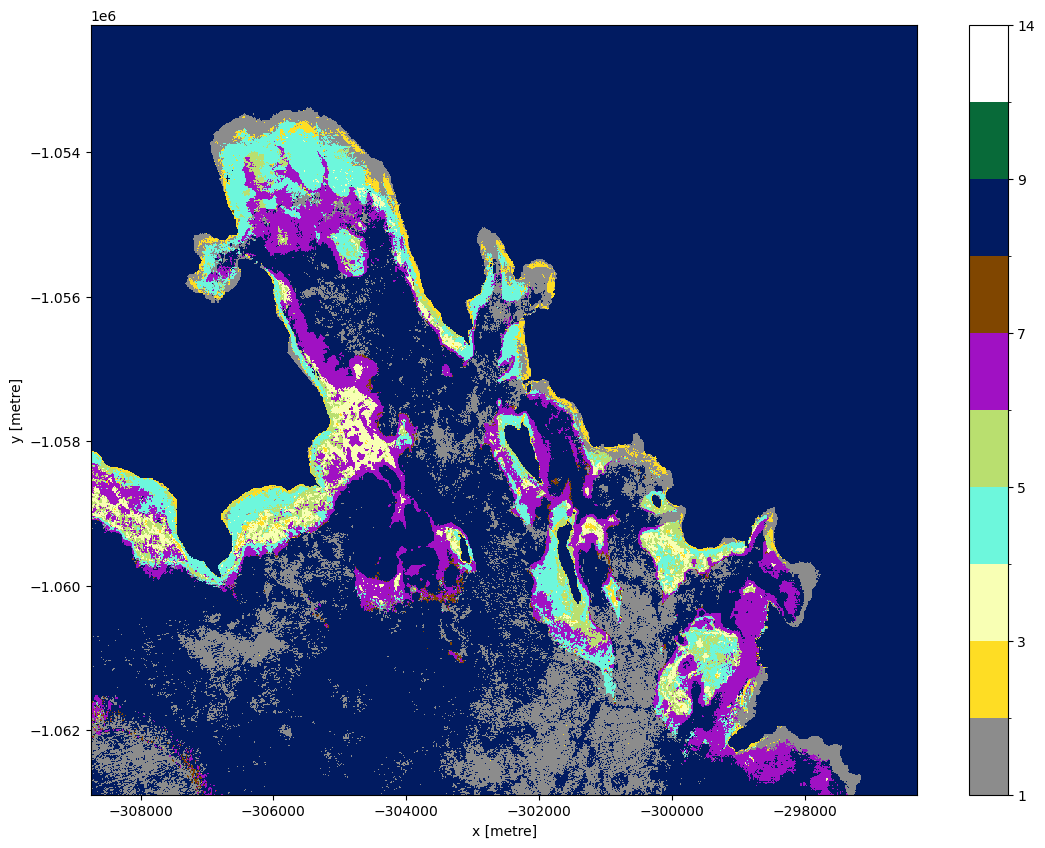

In [90]:
from matplotlib import colors

classes = [
    [1, "sediment", "#8c8c8c"],
    [2, "sand", "#fedd24"],
    [3, "rubble", "#f8ffb4"],
    [4, "seagrass", "#6df7dc"],
    [5, "seaweed", "#b9df6f"],
    [6, "coral", "#a011c3"],
    [7, "rock", "#804600"],
    [8, "deeps", "#011b61"],
    [9, "mangrove", "#086a39"],
    [10, "land", "#ffffff"],
]

values_list = [c[0] for c in classes]
color_list = [c[2] for c in classes]

# Build a listed colormap.
c_map = colors.ListedColormap(color_list)
bounds = values_list + [14]
norm = colors.BoundaryNorm(bounds, c_map.N)

predicted_da.plot.imshow(cmap=c_map, norm=norm, size=10)

In [92]:
predicted_da.odc.explore()

In [93]:
# issue where not all masks are being included - only land but not surf / also strange effect on side
predicted_da = predicted_da.where(all_masks)

In [94]:
predicted_da.odc.explore(cmap=c_map)

In [95]:
predicted_da.odc.write_cog("predicted_bootless_bay_15032025.tiff", overwrite=True)

PosixPath('predicted_bootless_bay_15032025.tiff')